## 2. **jpj_2_viz_data**
In this notebook, some investigative EDA was done and plots produced with possible ideas which could provide added value. In particular, the following were investigated:
1. Daily Volumes,
2. Busiest game types, and
3. Age of active players and their playing habits
    
From this EDA it was thus decided to try and model **Early Player Classification**.

In [234]:
import pandas as pd

import seaborn as sns
import calendar
import numpy as np

import warnings
warnings.filterwarnings('ignore')

In [7]:
# import dataframes
df_players = pd.read_pickle('./cleanedData/player_details.pkl')
df_tran    = pd.read_pickle('./cleanedData/tran.pkl')
df_games   = pd.read_pickle('./cleanedData/games.pkl')

# Tansaction Volumes
I would like to first understand the daily volumes being transacted

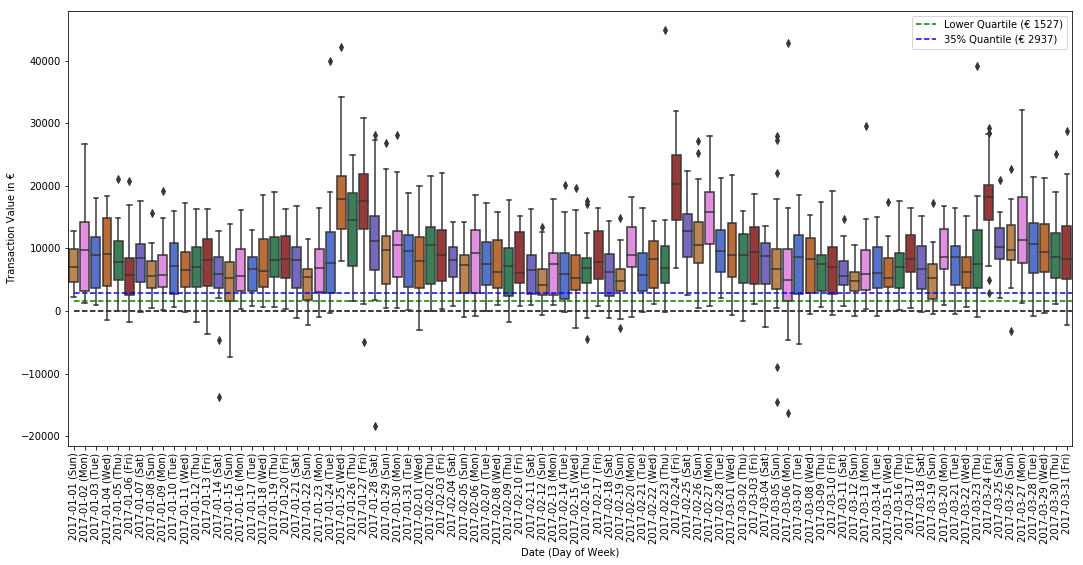

In [8]:
def switchDay(DD):
    if DD == 0:
        return 'Mon'
    elif DD == 1:
        return 'Tue'
    elif DD == 2:
        return 'Wed'
    elif DD == 3:
        return'Thu'
    elif DD == int(4):
        return 'Fri'
    elif DD == 5:
        return 'Sat'
    elif DD == 6:
        return 'Sun'

def plotViz1():
    dt = df_tran[(df_tran['payment_status']=='ACCEPTED') | (df_tran['payment_status']=='UNK' )]
    dt = dt.groupby(['created_datetime','created_date','created_time','created_day_of_week'],as_index=False)[['amount_EUR']].sum()
    dt['created_date_str'] = [str(d)[0:10] for d in dt['created_date'] ]
    dt['created_day_of_week_str'] = dt['created_day_of_week'].apply(switchDay)
    dt['x_axis'] = dt['created_date_str'] + ' ('+dt['created_day_of_week_str']+')'

    custom_palette = {}
    for ddate,dday in zip(dt['x_axis'],dt['created_day_of_week']):
        if dday ==1:
            custom_palette[ddate]= 'royalblue'
        elif dday ==2:
            custom_palette[ddate]= 'chocolate'
        elif dday ==3:
            custom_palette[ddate]= 'seagreen'
        elif dday ==4:
            custom_palette[ddate]= 'brown'
        elif dday ==5:
            custom_palette[ddate]= 'slateblue'
        elif dday ==6:
            custom_palette[ddate]= 'peru'
        elif dday ==0:
            custom_palette[ddate]= 'violet'

    dt2 = dt.groupby(['created_date','x_axis'],as_index=False)[['amount_EUR']].mean()
    dt3 = dt.groupby(['created_date','x_axis'],as_index=False)[['amount_EUR']].quantile(.25)
    dt4 = dt.groupby(['created_date','x_axis'],as_index=False)[['amount_EUR']].quantile(.35)

    fig, ax = plt.subplots(figsize=(18,8))
    sns.boxplot(data=dt, x="x_axis",y="amount_EUR",palette=custom_palette)
    plt.hlines(y=0, xmin=0,xmax=90, linestyles='--')
    # plt.hlines(y=min(dt2['amount_EUR']), xmin=0,xmax=90, linestyles='--',color='b',label='Lowest Daily Avg')
    plt.hlines(y=min(dt3['amount_EUR']), xmin=0,xmax=90, linestyles='--',color='g',
               label= 'Lower Quartile (€ '+str(int(min(dt3['amount_EUR'])))+')' ) 
    plt.hlines(y=min(dt4['amount_EUR']), xmin=0,xmax=90, linestyles='--',color='b',
               label= '35% Quantile (€ '+str(int(min(dt4['amount_EUR'])))+')' ) 
    plt.ylabel('Transaction Value in €')
    plt.xlabel('Date (Day of Week)')
    plt.xticks(rotation=90)
    plt.legend()
    plt.show()
plotViz1()

The above plot shows the volumne & spread of transactions on a daily basis for the given 3 month period. This allows us to identify:
 - Highest volumes are occuring close to the last Fri of every month (24th-28th)....Could this be correlated with pay day? Possibly lauching of new games should be close to this time as this is when customers have the highest amounts of money on account.
 - Mid month (10th - 20th) shows the lowest volumes. We should be promoting more games here. Possibly give bonuses and recommend new games. Need to incentivise. 
 - Given a bank overdraft available to the organisation, there is potential savings of €1,527 readily available on a daily basis. If a healthier bank overdraft is available, we could possibly be looking into €2,937 daily. €137,430 - €264,330 could be invested elsewhere based on the above 3 months

# Which are the busiest game types?

In [9]:
dt = pd.merge(df_tran,df_games,how='left', left_on='gameid', right_on='gameid')
dt = pd.merge(dt,df_players, how='left', left_on='playerid', right_on='playerid')
dt = dt[(dt['trans_type'] == 'WAGER') | (dt['trans_type'] == 'WINNING')]
dt = dt.groupby(['created_month_name','Country','Country_Lat', 'Country_Long','categorycode'],as_index=False)[['amount_EUR','transaction_count']].sum()

In [10]:
def zScore(col):
    return ( col - col.mean() ) / col.std(ddof=0)
# standard score across ALL
dt['Zscore_value_global']= zScore(dt['amount_EUR'] )
dt['Zscore_tran_global'] = zScore(dt['transaction_count'] )
# standardizing based on all available data on monthly basis
dt['Zscore_value_global_monthly']= dt.groupby(['created_month_name'],as_index=False)[['amount_EUR']].transform(zScore)
dt['Zscore_tran_global_monthly'] = dt.groupby(['created_month_name'],as_index=False)[['transaction_count']].transform(zScore)
# standardizing based on Country
dt['Zscore_value_monthly_country'] = dt.groupby(['created_month_name','Country'],as_index=False)[['amount_EUR']].transform(zScore)
dt['Zscore_tran_monthly_country'] = dt.groupby(['created_month_name','Country'],as_index=False)[['transaction_count']].transform(zScore)
dt['Zscore_value_global_country'] = dt.groupby(['Country'],as_index=False)[['amount_EUR']].transform(zScore)
dt['Zscore_tran_global_country'] = dt.groupby(['Country'],as_index=False)[['transaction_count']].transform(zScore)
# standardizing based on Game Category
dt['Zscore_value_monthly_categorycode'] = dt.groupby(['created_month_name','categorycode'],as_index=False)[['amount_EUR']].transform(zScore)
dt['Zscore_tran_monthly_categorycode'] = dt.groupby(['created_month_name','categorycode'],as_index=False)[['transaction_count']].transform(zScore)
dt['Zscore_value_global_categorycode'] = dt.groupby(['categorycode'],as_index=False)[['amount_EUR']].transform(zScore)
dt['Zscore_tran_global_categorycode'] = dt.groupby(['categorycode'],as_index=False)[['transaction_count']].transform(zScore)

In [11]:
TOP = 10
top_countries_tran_count = dt.groupby(['Country'])['transaction_count'].sum().nlargest(TOP).index.tolist()

In [12]:
dt2 = dt[dt['Country'].isin(top_countries_tran_count)]
def countryInitials(COUNTRY):
    if COUNTRY == 'Sweden':
        return 'SW'
    elif COUNTRY ==  'Indonesia':
        return 'IND'
    elif COUNTRY ==  'United States Of America': 
        return 'USA'
    elif COUNTRY ==  'Denmark':
        return 'DEN'
    elif COUNTRY == 'Cameroon': 
        return 'CAM'
    elif COUNTRY ==  'South Africa': 
        return 'SA'
    elif COUNTRY ==  'Estonia': 
        return 'EST'
    elif COUNTRY ==  'Russia': 
        return 'RUS'
    elif COUNTRY ==  'Eritrea': 
        return 'ERI'
    elif COUNTRY ==  'Norway':
        return 'NOR'
dt2['Country_Initials'] = dt2['Country'].apply(countryInitials)

dt3 = pd.melt(dt2,
              id_vars=['Country_Initials','created_month_name','Country','Country_Lat','Country_Long','categorycode'],
              value_vars=['amount_EUR','transaction_count','Zscore_value_global','Zscore_tran_global',
                          'Zscore_value_global_monthly','Zscore_tran_global_monthly','Zscore_value_monthly_country',
                          'Zscore_tran_monthly_country','Zscore_value_global_country','Zscore_tran_global_country',
                          'Zscore_value_monthly_categorycode','Zscore_tran_monthly_categorycode',
                          'Zscore_value_global_categorycode','Zscore_tran_global_categorycode'] )

/Users/Chris/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [13]:
# def gamesPlot(mmonth,val):
#     sns.barplot(data=dt2[dt2['created_month_name']==mmonth],
#             x="Country_Initials", y=val,
#             hue='categorycode')
# #     plt.xticks(rotation=45)
#     plt.xlabel('')
    

# fig, ax = plt.subplots(nrows=3,ncols=2,figsize=(18,10))
# plt.subplot(321)
# gamesPlot('Jan','amount_EUR')
# plt.subplot(322)
# gamesPlot('Jan','transaction_count')
# plt.subplot(323)
# gamesPlot('Feb','amount_EUR')
# plt.subplot(324)
# gamesPlot('Feb','transaction_count')
# plt.subplot(325)
# gamesPlot('Mar','amount_EUR')
# plt.subplot(326)
# gamesPlot('Mar','transaction_count')


Sweden : SW, Indonesia : IND, United States Of America : USA, Denmark : DEN, Cameroon : CAM,
South Africa : SA, Estonia : EST, Russia : RUS, Eritrea : ERI, Norway : NOR


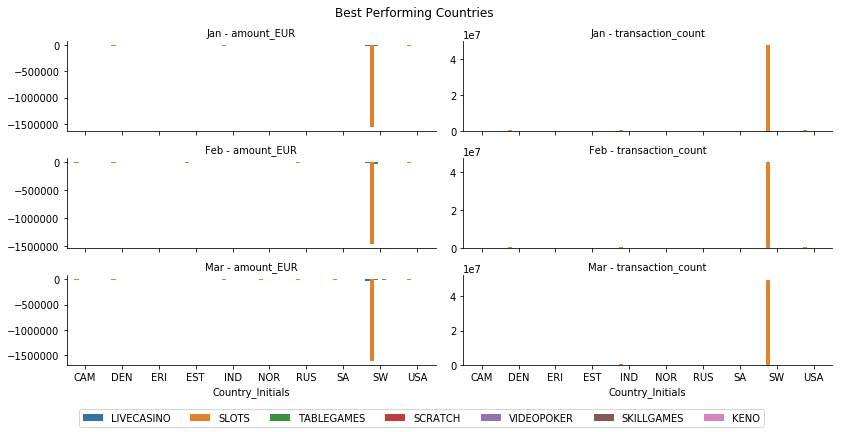

In [14]:
def plotViz2(DATA,TITLE):
    print('''Sweden : SW, Indonesia : IND, United States Of America : USA, Denmark : DEN, Cameroon : CAM,
South Africa : SA, Estonia : EST, Russia : RUS, Eritrea : ERI, Norway : NOR''')
    g = sns.catplot(data=DATA,
                   x='Country_Initials',y='value', col='variable', row='created_month_name', hue = 'categorycode', kind='bar',
                   row_order =['Jan','Feb','Mar'], height = 2, aspect=3,sharey=False, legend=False)
    g.set_titles("{row_name} - {col_name}")
    g.set_ylabels('')
    handles = g._legend_data.values()
    labels = g._legend_data.keys()
    g.fig.legend(handles=handles, labels=labels, loc='lower center', ncol=7)
    g.fig.subplots_adjust(top=0.9, bottom=0.15)
    g.fig.suptitle(TITLE)
plotViz2(DATA = dt3[dt3['variable'].isin(['amount_EUR','transaction_count'])],
        TITLE = 'Best Performing Countries')    

Swedish slots are dominating all amounts and transaction counts. There is thus a definite concentration of our market. Let us look at the other countries.

Sweden : SW, Indonesia : IND, United States Of America : USA, Denmark : DEN, Cameroon : CAM,
South Africa : SA, Estonia : EST, Russia : RUS, Eritrea : ERI, Norway : NOR


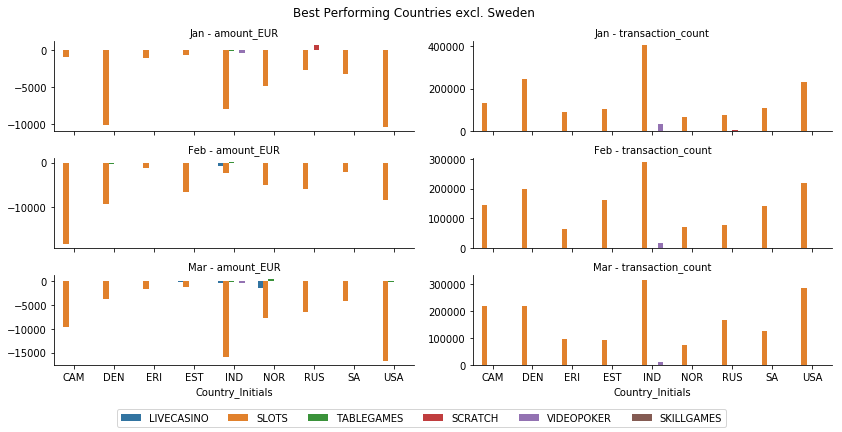

In [15]:
plotViz2(DATA=dt3[(dt3['variable'].isin(['amount_EUR','transaction_count']))
                  & (dt3['Country_Initials']!='SW')],
        TITLE= 'Best Performing Countries excl. Sweden') 

Slots is dominant. What is the distribution without slots?

Sweden : SW, Indonesia : IND, United States Of America : USA, Denmark : DEN, Cameroon : CAM,
South Africa : SA, Estonia : EST, Russia : RUS, Eritrea : ERI, Norway : NOR


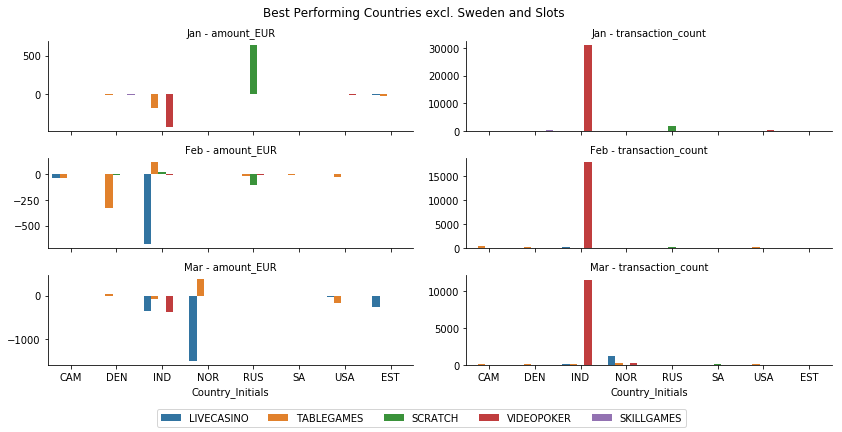

In [16]:
plotViz2(DATA=dt3[(dt3['variable'].isin(['amount_EUR','transaction_count'])) 
                  & (dt3['Country_Initials']!='SW') 
                  & (dt3['categorycode'] != 'SLOTS')],
        TITLE= 'Best Performing Countries excl. Sweden and Slots') 

Hmm, so IND have been playing video poker a lot....Different players in different countries like different games (trivial...but confirmed)

# What are the ages of these players? What do they like playing?

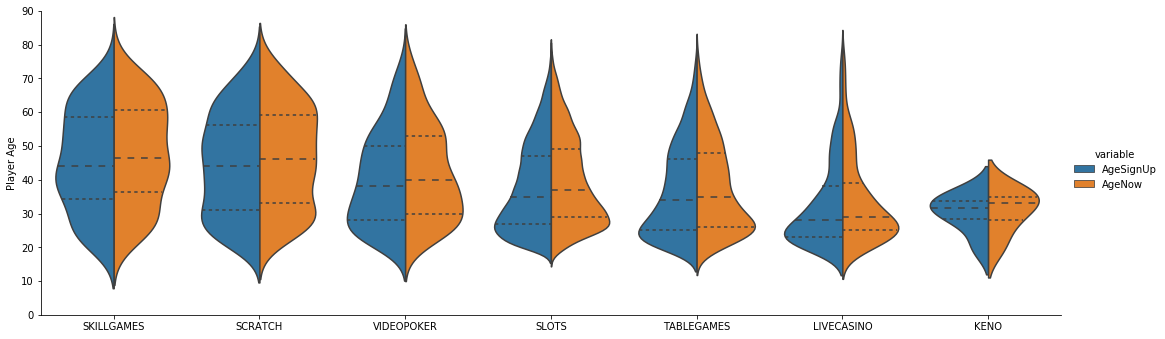

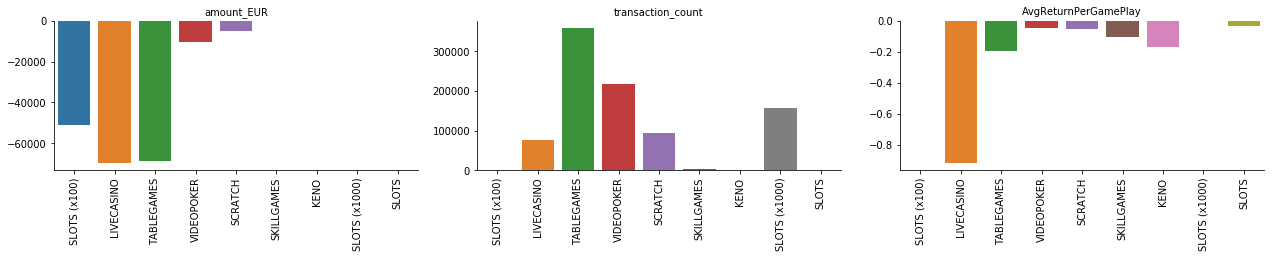

In [235]:
dt = pd.merge(df_tran,df_games,how='left', left_on='gameid', right_on='gameid')
dt = pd.merge(dt,df_players, how='left', left_on='playerid', right_on='playerid')
# selecting only players that are active
dt = dt[(dt['payment_status']=='ACCEPTED') | (dt['payment_status']=='UNK' )]
dt = dt[dt['categorycode'] != 'UNK']
dt = dt[dt['birth_year'] >= 1940 ]
dt = dt[dt['AgeSignUp'] >= 18]
dt = dt.groupby(['playerid','categorycode','AgeNow','AgeSignUp','Age_jpj'],as_index=False)[['amount_EUR','transaction_count']].sum()

dt2 = dt.groupby(['categorycode','AgeNow','AgeSignUp'],as_index=False)[['playerid']].count()
dt2 = pd.melt(dt,id_vars=['categorycode','playerid'], value_vars=['AgeNow','AgeSignUp'])
dt2.columns = ['categorycode','freq','variable','value']

dt2 = dt.groupby(['categorycode','AgeNow','AgeSignUp'],as_index=False)[['playerid']].count()
dt2 = pd.melt(dt,id_vars=['categorycode','playerid'], value_vars=['AgeNow','AgeSignUp'])
dt2.columns = ['categorycode','freq','variable','value']
dt2.drop_duplicates(inplace=True)
dt2

#order by eldest mean AgeSignUp first
dt_rank = dt.groupby(['categorycode'],as_index=False)[['AgeSignUp']].mean().sort_values(by='AgeSignUp',ascending=False)['categorycode'].tolist()

def viz3Violin():
    g = sns.catplot(data=dt2,x='categorycode',y='value',kind='violin',inner="quartile",
                hue='variable',split=True,hue_order=['AgeSignUp','AgeNow'],height = 5,
                    aspect=3,order = dt_rank)
    g.set_titles("{col_name}")
    g.set_ylabels('Player Age')
    g.set_xlabels('')
    g.set(ylim=(0, 90))

# bar plots
dt3 = pd.merge(df_tran,df_games,how='left', left_on='gameid', right_on='gameid')
dt3 = pd.merge(dt3,df_players, how='left', left_on='playerid', right_on='playerid')
# selecting only players that are active
dt3 = dt3[(dt3['payment_status']=='ACCEPTED') | (dt3['payment_status']=='UNK' )]
dt3 = dt3[dt3['categorycode'] != 'UNK']
dt3 = dt3[dt3['birth_year'] >= 1940 ]
dt3 = dt3[dt3['AgeSignUp'] >= 18]
dt4 = dt3.groupby(['categorycode'],as_index=False)[['amount_EUR','transaction_count']].sum().sort_values(by='amount_EUR')
dt4['AvgReturnPerGamePlay'] = dt4['amount_EUR']/dt4['transaction_count']
dt4 = pd.melt(dt4,id_vars=['categorycode'],value_vars=['amount_EUR','transaction_count','AvgReturnPerGamePlay'])

# renaming and sclaing down of SLOTS amounts_EUR & transaction_count
dt4['value'][(dt4['variable'] == 'amount_EUR') & (dt4['categorycode']=='SLOTS')] = dt4['value'][(dt4['variable'] == 'amount_EUR') & (dt4['categorycode']=='SLOTS')] / 100
dt4['categorycode'][(dt4['variable'] == 'amount_EUR') & (dt4['categorycode']=='SLOTS')] = 'SLOTS (x100)'

dt4['value'][(dt4['variable'] == 'transaction_count') & (dt4['categorycode']=='SLOTS')] = dt4['value'][(dt4['variable'] == 'transaction_count') & (dt4['categorycode']=='SLOTS')] / 1000
dt4['categorycode'][(dt4['variable'] == 'transaction_count') & (dt4['categorycode']=='SLOTS')] = 'SLOTS (x1000)'

def viz3Bar():
    g = sns.catplot(data=dt4,x='categorycode',y='value', col='variable',
                kind='bar',sharey=False, height=3, aspect=2)
    g.set_titles("{col_name}")
    g.set_ylabels('')
    g.set_xlabels('')
    g.set_xticklabels(rotation=90)

# plot both
viz3Violin()
viz3Bar()

Comments from above:
- SKILLGAMES & SCRATCH are more popular with the elder segment of the pupulation, however they offer the lowest returns having a low Avg Return per Play. That said, the players tend to be loyal, with a wide distance between mean Age of Sign Up and mean Age Now. Indeed, both violin plots have good girth across the Age of players.
- Younger players tende to play SLOTS, TABLEGAMES, LIVECASINO and KENO. This is particularly good for LIVECASINO as this game type offers the best Return on Per Game Play, with the second best gross return in €.
- LIVECASINO players have a narrow distance between mean Age at SignUp and mean Age Now, possibly indicating that these type of players tend to Sign Up and play immediately. Somehow, they are loosing interest in LIVECASINO as they are getting older since the violin plot gets narrow with age.

So based on the data available, we can already start seeing some different patterns on how players are playing, when they play, which games they like p....resulting in different players segmentations.